In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from alphatoe import plot, game, interpretability
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from importlib import reload
from copy import copy
import pandas as pd
import random

In [3]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)

In [4]:
seq_fwd = torch.tensor([[10, 0, 1, 2, 3, 4, 5, 6, 7, 8]])
seq_fwd.shape

torch.Size([1, 10])

In [5]:
pos_emb = model.pos_embed(seq_fwd, 0)
logits_mlp_pos = model.blocks[0].mlp(pos_emb) @ model.W_U
preds_mlp_pos = torch.softmax(logits_mlp_pos, axis=-1)
print(pos_emb.shape)
logits_mlp_pos.shape, preds_mlp_pos.shape

torch.Size([1, 10, 128])


(torch.Size([1, 10, 10]), torch.Size([1, 10, 10]))

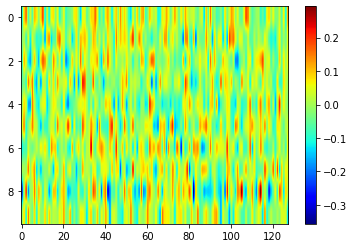

In [6]:
plt.imshow(pos_emb[0].detach().cpu().numpy(), aspect='auto', cmap="jet")
plt.colorbar()

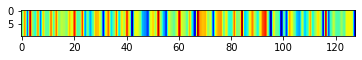

In [7]:
injected_pos = pos_emb[:, -1, :].expand(1, 10, 128)
plt.imshow(injected_pos[0].detach().cpu().numpy(), cmap="jet")

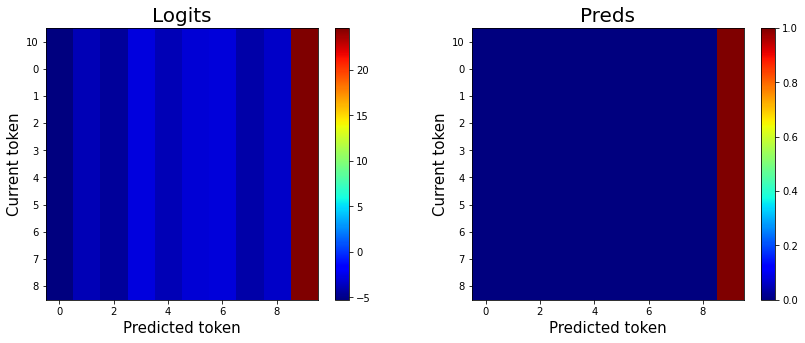

In [8]:
logits_injected = model.blocks[0].mlp(injected_pos) @ model.W_U
interpretability.plot_predictions(seq_fwd[0].tolist(), logits_injected)

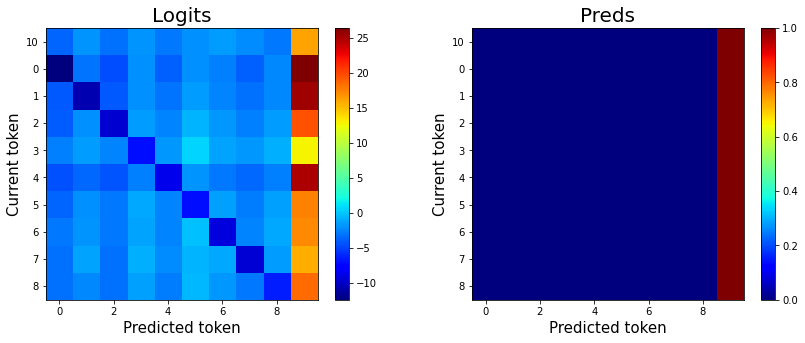

In [9]:
content_emb = model.embed(seq_fwd)
embeddings = content_emb + injected_pos
logits_emb = model.blocks[0].mlp(embeddings) @ model.W_U
interpretability.plot_predictions(seq_fwd[0].tolist(), logits_emb)

In [10]:
def inject_posemb(seq, injected_pos_emb):
    def hook(module, input, output):
        return injected_pos_emb
    
    try:
        handle = model.hook_pos_embed.register_forward_hook(hook)
        logits = model(seq)
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e
    return logits

In [11]:
injected_logits = inject_posemb(seq_fwd[0], injected_pos)

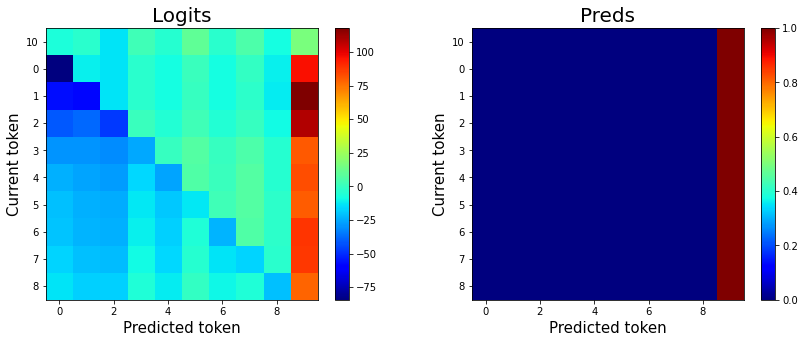

In [12]:
interpretability.plot_predictions(seq_fwd[0].tolist(), injected_logits)

In [13]:
logits_true = model(seq_fwd[0])
logits_control = inject_posemb(seq_fwd[0], pos_emb)
#sum across all dimensions
print((logits_true-logits_control).sum())

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)


In [14]:
def neuron_posembed_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result
        
    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model.blocks[0].mlp(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

def neuron_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result
        
    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

In [15]:
test = neuron_posembed_activations(pos_emb)
test.shape

torch.Size([1, 10, 512])

In [16]:
last_token_acts = test[0][-1].detach().cpu().numpy()

In [17]:
print(np.count_nonzero(last_token_acts))
print(np.count_nonzero(last_token_acts) / last_token_acts.size)

292
0.5703125


In [18]:
last_token_2d = last_token_acts[np.newaxis, :]
last_token_2d.shape

(1, 512)

Text(0.5, 0, 'Neuron')

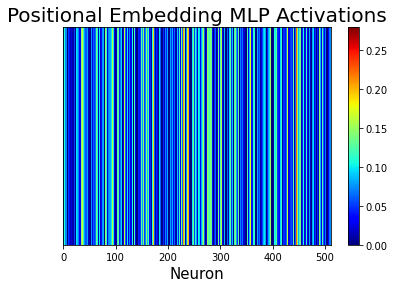

In [19]:
#plot last token acts imshow
plt.imshow(last_token_2d, aspect="auto", cmap="jet")
plt.colorbar()
#figsize params
plt.rcParams['figure.figsize'] = 10, 5
#title
plt.title("Positional Embedding MLP Activations", fontsize=20)
plt.gcf().set_facecolor("white")
#y tick
plt.yticks([1])
#x label
plt.xlabel("Neuron", fontsize=15)


In [20]:
games = pd.read_csv('../data/prob all 8 layer control-20230718-185339_stats.csv')
games.head()

/tmp/ipykernel_118646/1995611786.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv('../data/prob all 8 layer control-20230718-185339_stats.csv')


,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


In [21]:
nine_move_games = [[10]+eval(move) for move in games[games['steps till end state'] == 9]['moves played']]

In [22]:
activations = []
for _ in range(500):
    data = torch.tensor(random.choice(nine_move_games))
    activations.append(neuron_activations(data)[0][-1])

In [23]:
stacked_acts = torch.stack(activations)
activation_counts = (stacked_acts != 0).sum(dim=0)
activation_frequency = activation_counts / stacked_acts.shape[0]
activation_frequency = activation_frequency.detach().cpu().numpy()
activation_frequency = activation_frequency[np.newaxis, :]

Text(0.5, 0, 'Neuron')

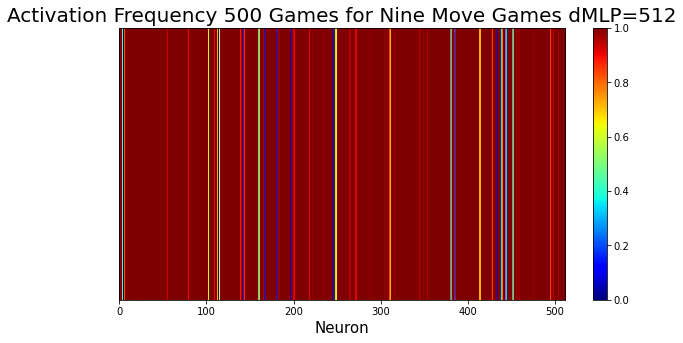

In [24]:
#plot last token acts imshow
plt.imshow(activation_frequency, aspect="auto", cmap="jet")
plt.colorbar()
#figsize params
plt.rcParams['figure.figsize'] = 12, 6
#title
plt.title("Activation Frequency 500 Games for Nine Move Games dMLP=512", fontsize=20)
plt.gcf().set_facecolor("white")
#y tick
plt.yticks([1])
#x label
plt.xlabel("Neuron", fontsize=15)

Text(0.5, 0, 'Neuron')

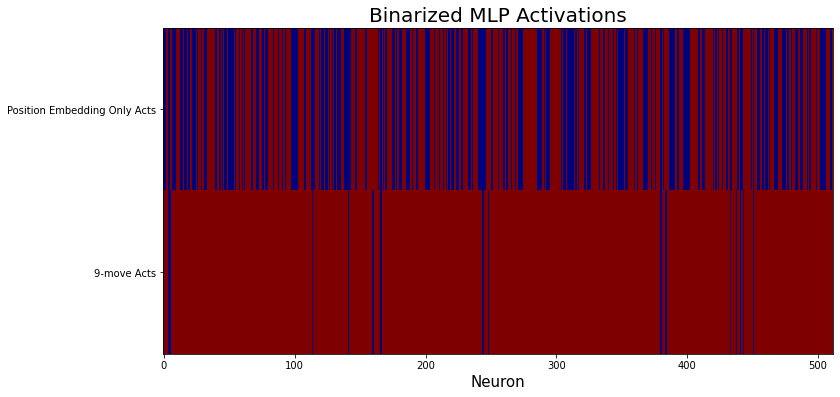

In [25]:
pos_acts = (last_token_2d[0] != 0)
acts_nine_move = (activation_frequency[0] != 0)
acts = [pos_acts, acts_nine_move]
#imshow booleans
plt.imshow(acts, aspect='auto', cmap="jet", figure=plt.figure(figsize=(12, 6)), interpolation='none')
#yticks
plt.yticks(np.arange(len(acts)), labels=["Position Embedding Only Acts", "9-move Acts"])
plt.gcf().set_facecolor("white")
#title
plt.title("Binarized MLP Activations", fontsize=20)
#xlabel
plt.xlabel("Neuron", fontsize=15)